In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
import os
os.mkdir('models')

BASE_MODEL_PATH = 'models/base_model.pth'
F_MODEL_PATH = 'models/f_model.pth'
F1_MODEL_PATH = 'models/f1_model.pth'

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 138382742.79it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 102831658.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37440673.23it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1258873.24it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [6]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

##Attack

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [8]:
model = Net().to(device)

In [9]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [10]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return model,train_loss,val_loss

In [11]:
model,loss,val_loss=fit(model,device,train_loader,val_loader,10)
torch.save(model, BASE_MODEL_PATH)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.2790134729875901 Val_Loss: 0.12788857415765637
Epoch: 2 Loss: 0.1044248428797856 Val_Loss: 0.10640370054425302
Epoch: 3 Loss: 0.08291679169441352 Val_Loss: 0.09817019602792544
Epoch: 4 Loss: 0.07277324726523082 Val_Loss: 0.10649383694323185
Epoch: 5 Loss: 0.06715249750090072 Val_Loss: 0.09011895514189992
Epoch: 6 Loss: 0.06605494884855573 Val_Loss: 0.08582559542205498
Epoch: 7 Loss: 0.06534249143363044 Val_Loss: 0.08518667414238933
Epoch: 8 Loss: 0.062260958825676546 Val_Loss: 0.09284054386769026
Epoch: 9 Loss: 0.06066756256896291 Val_Loss: 0.0895826131838466
Epoch: 10 Loss: 0.05870173529754892 Val_Loss: 0.08433067725071966


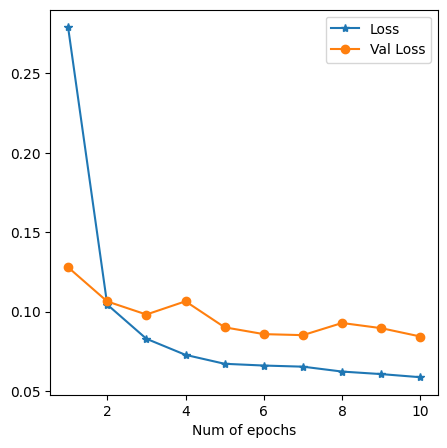

In [12]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [13]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [14]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9684 / 10000 = 0.9684
Epsilon: 0.007	Test Accuracy = 9653 / 10000 = 0.9653
Epsilon: 0.01	Test Accuracy = 9640 / 10000 = 0.964
Epsilon: 0.02	Test Accuracy = 9590 / 10000 = 0.959
Epsilon: 0.03	Test Accuracy = 9498 / 10000 = 0.9498
Epsilon: 0.05	Test Accuracy = 9280 / 10000 = 0.928
Epsilon: 0.1	Test Accuracy = 8361 / 10000 = 0.8361
Epsilon: 0.2	Test Accuracy = 4940 / 10000 = 0.494
Epsilon: 0.3	Test Accuracy = 2425 / 10000 = 0.2425


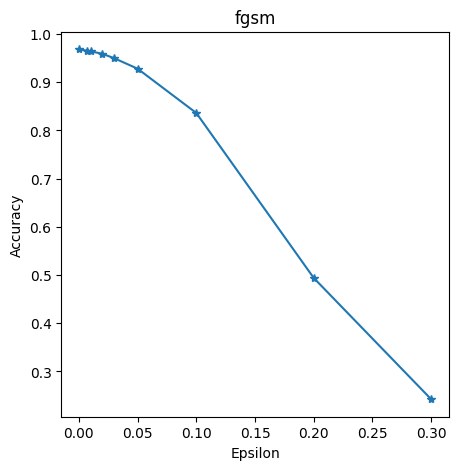

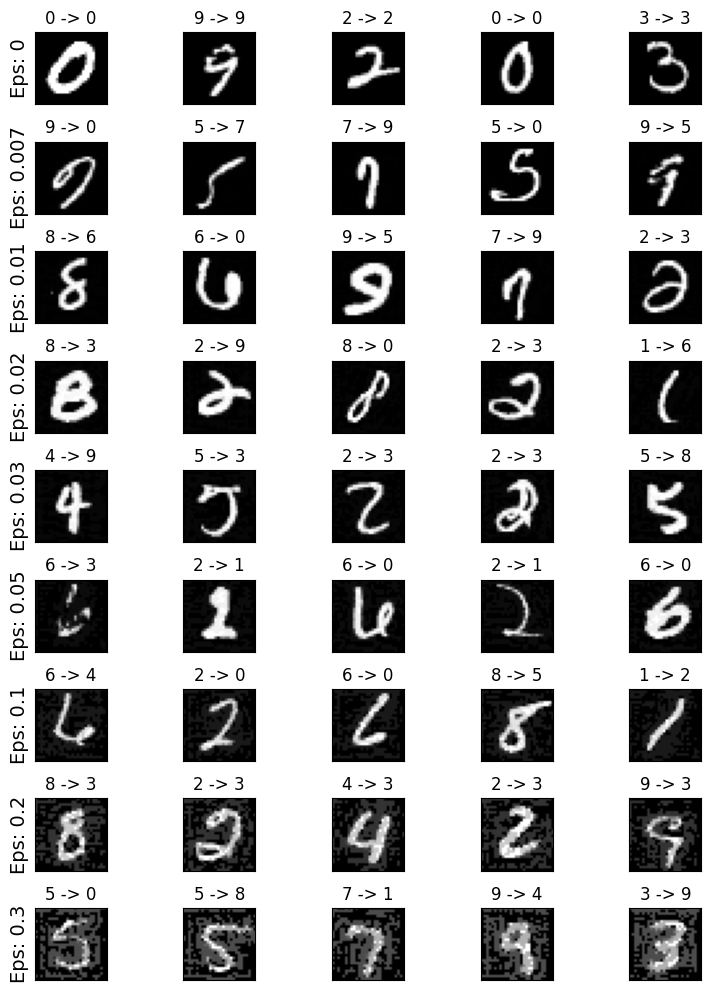

Epsilon: 0	Test Accuracy = 9694 / 10000 = 0.9694
Epsilon: 0.007	Test Accuracy = 9648 / 10000 = 0.9648
Epsilon: 0.01	Test Accuracy = 9615 / 10000 = 0.9615
Epsilon: 0.02	Test Accuracy = 9585 / 10000 = 0.9585
Epsilon: 0.03	Test Accuracy = 9547 / 10000 = 0.9547
Epsilon: 0.05	Test Accuracy = 9350 / 10000 = 0.935
Epsilon: 0.1	Test Accuracy = 8609 / 10000 = 0.8609
Epsilon: 0.2	Test Accuracy = 5719 / 10000 = 0.5719
Epsilon: 0.3	Test Accuracy = 3023 / 10000 = 0.3023


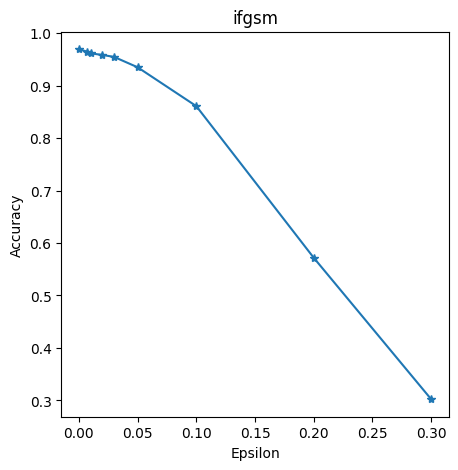

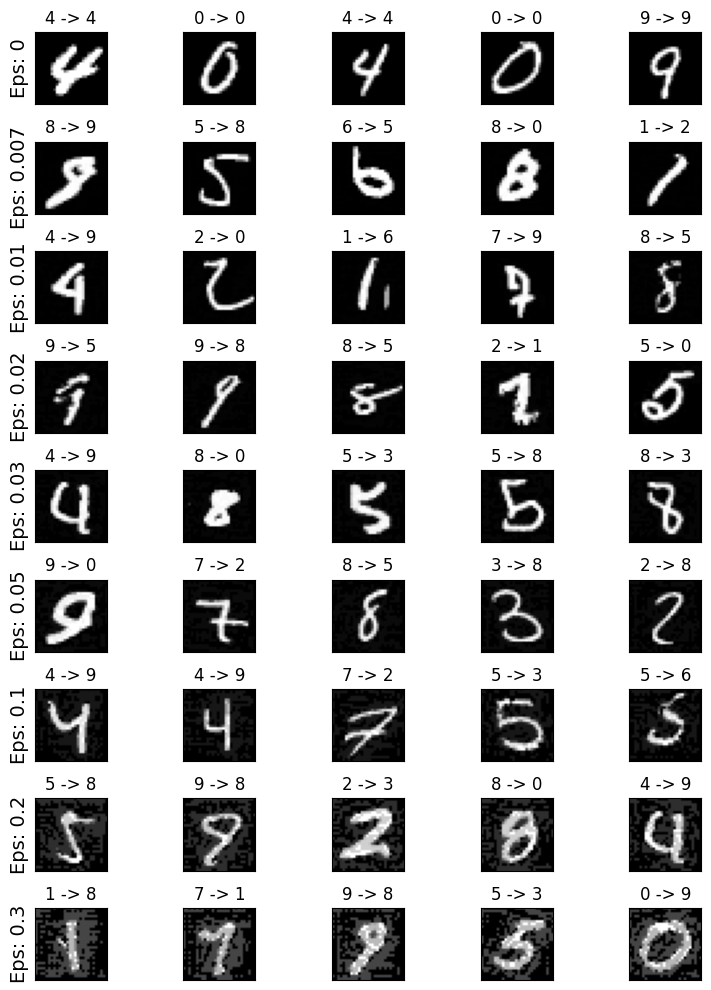

Epsilon: 0	Test Accuracy = 9711 / 10000 = 0.9711
Epsilon: 0.007	Test Accuracy = 9665 / 10000 = 0.9665
Epsilon: 0.01	Test Accuracy = 9646 / 10000 = 0.9646
Epsilon: 0.02	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.03	Test Accuracy = 9539 / 10000 = 0.9539
Epsilon: 0.05	Test Accuracy = 9358 / 10000 = 0.9358
Epsilon: 0.1	Test Accuracy = 8549 / 10000 = 0.8549
Epsilon: 0.2	Test Accuracy = 5686 / 10000 = 0.5686
Epsilon: 0.3	Test Accuracy = 3028 / 10000 = 0.3028


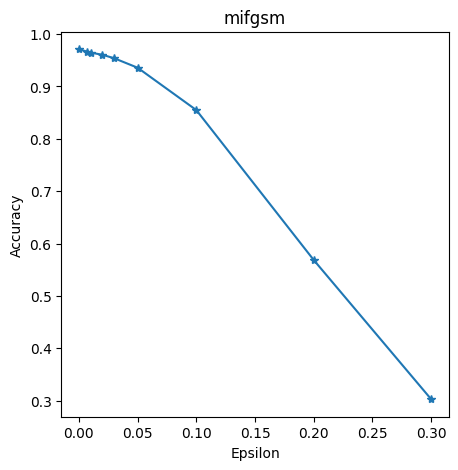

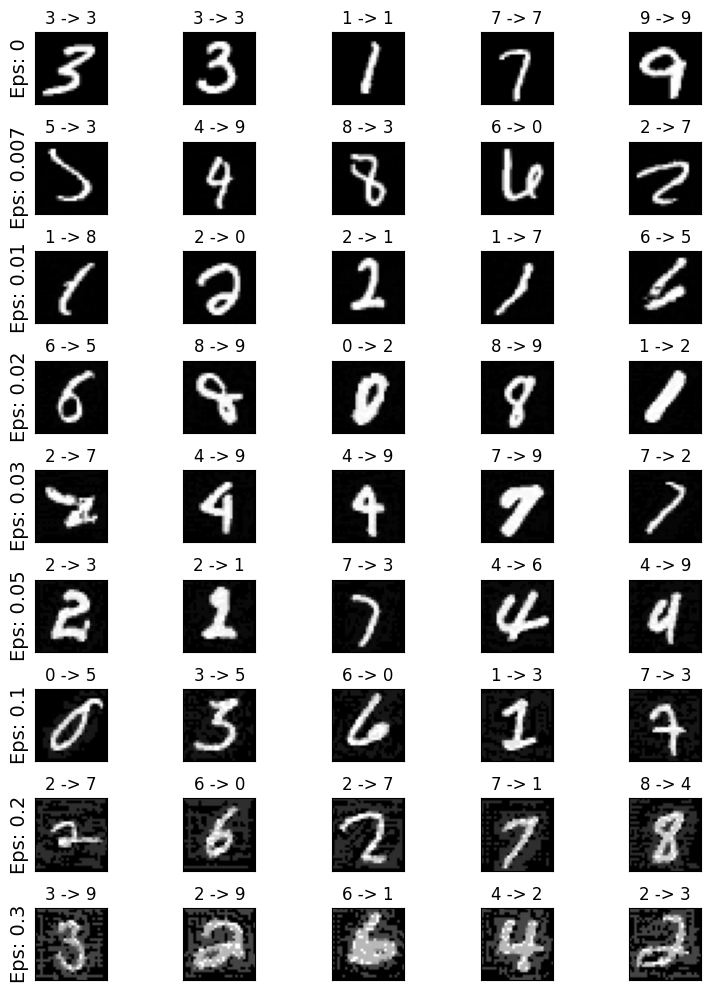

In [15]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

##Defense

In [16]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [17]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [18]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return model,train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [19]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  model,lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  torch.save(model, F_MODEL_PATH)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  model,lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  torch.save(model, F1_MODEL_PATH)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)

    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1 Loss: 0.5149505667673095 Val_Loss: 0.3525582709565243
Epoch: 2 Loss: 0.3196094123777367 Val_Loss: 0.2999350535038583
Epoch: 3 Loss: 0.2433849027152442 Val_Loss: 0.22430034668890095
Epoch: 4 Loss: 0.18578366565325916 Val_Loss: 0.17208063055432807
Epoch: 5 Loss: 0.14521693623035756 Val_Loss: 0.14278872974310725
Epoch: 6 Loss: 0.12365582980706058 Val_Loss: 0.13111915796836693
Epoch: 7 Loss: 0.1080425527796751 Val_Loss: 0.1200235042896697
Epoch: 8 Loss: 0.09698787090071144 Val_Loss: 0.11812433607828773
Epoch: 9 Loss: 0.09013582577581263 Val_Loss: 0.1074698378592232
Epoch: 10 Loss: 0.08510949592064247 Val_Loss: 0.11354223553426146


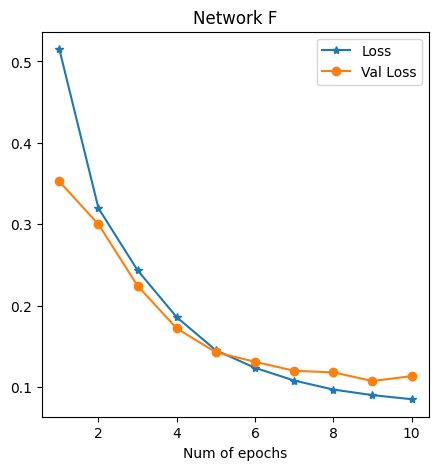

Fitting the model...
Epoch: 1 Loss: 0.6794741857070038 Val_Loss: 0.5064548063184512
Epoch: 2 Loss: 0.4583026400204363 Val_Loss: 0.4334107960836301
Epoch: 3 Loss: 0.3932987828726726 Val_Loss: 0.38284573877370837
Epoch: 4 Loss: 0.3437598772299374 Val_Loss: 0.3294363585175398
Epoch: 5 Loss: 0.28857758094572844 Val_Loss: 0.28968612721948994
Epoch: 6 Loss: 0.25234114931114493 Val_Loss: 0.24846928071653218
Epoch: 7 Loss: 0.22344904530275228 Val_Loss: 0.23076282498062
Epoch: 8 Loss: 0.2034543221949281 Val_Loss: 0.20801051328413983
Epoch: 9 Loss: 0.18834721537654656 Val_Loss: 0.20652503564477928
Epoch: 10 Loss: 0.17071371254904602 Val_Loss: 0.18326100961577305


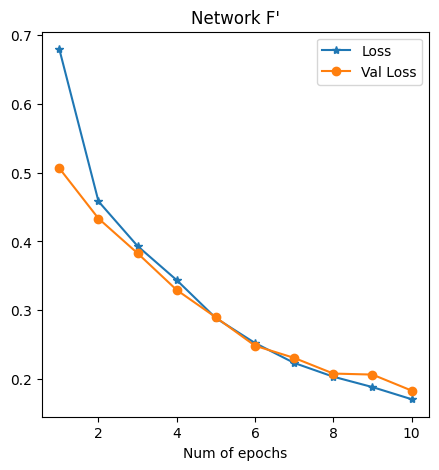

Epsilon: 0	Test Accuracy = 9265 / 10000 = 0.9265
Epsilon: 0.007	Test Accuracy = 9245 / 10000 = 0.9245
Epsilon: 0.01	Test Accuracy = 9261 / 10000 = 0.9261
Epsilon: 0.02	Test Accuracy = 9255 / 10000 = 0.9255
Epsilon: 0.03	Test Accuracy = 9244 / 10000 = 0.9244
Epsilon: 0.05	Test Accuracy = 9207 / 10000 = 0.9207
Epsilon: 0.1	Test Accuracy = 9158 / 10000 = 0.9158
Epsilon: 0.2	Test Accuracy = 9153 / 10000 = 0.9153
Epsilon: 0.3	Test Accuracy = 9052 / 10000 = 0.9052


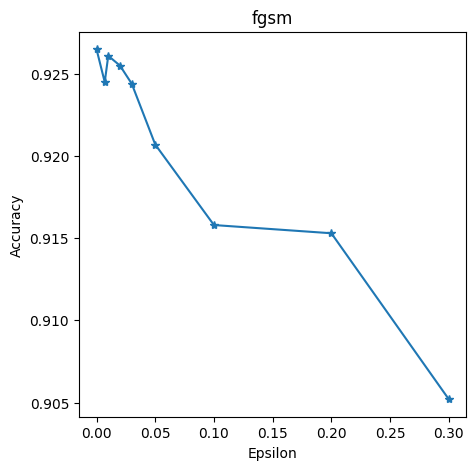

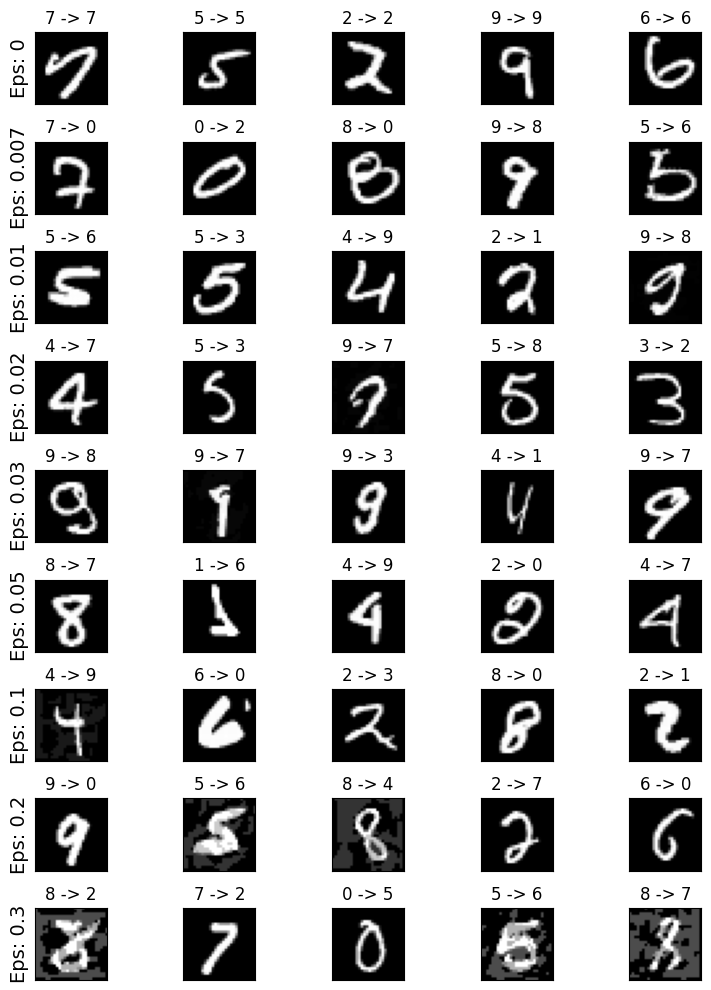

In [ ]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)